In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import dask
import earthkit.plots
import numpy as np
import xarray as xr
from numcodecs.abc import Codec

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5_U = ERA5["u"].sel(valid_time="2024-04-02T12:00:00")

In [4]:
import copy


def plot_data(
    da: xr.DataArray,
    title_prefix="",
    title_postfix="",
    error=False,
    n_levels=256,
    cmap=None,
    divergence_point=None,
    levels=None,
    ticks=None,
    chart=None,
    **kwargs,
):
    UNITS = dict(t2m="degC")
    DIVERGENCE_POINT = dict(t2m=0.0)

    units = None if error else UNITS.get(da.name, None)
    divergence_point = (
        divergence_point
        if divergence_point is not None
        else 0.0
        if error
        else DIVERGENCE_POINT.get(da.name, None)
    )

    source = earthkit.plots.sources.XarraySource(da)

    # compute the default style that earthkit.maps would apply
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=units or source.units,
        )
    )

    da_units = style.convert_units(da.values, source.units)

    # modify the style levels to get a smoother colourbar
    style._levels = earthkit.plots.styles.levels.Levels(
        levels
        if levels is not None
        else earthkit.plots.styles.levels.auto_range(
            da_units,
            divergence_point=divergence_point,
            n_levels=n_levels,
        )
    )
    style._legend_kwargs["ticks"] = (
        earthkit.plots.styles.levels.auto_range(
            da_units,
            divergence_point=divergence_point,
            n_levels=10,
        )
        if ticks is None
        else ticks
    )

    style._kwargs.update(kwargs)

    # force the colourmap to coolwarm for error plots
    style._colors = cmap if cmap is not None else "coolwarm" if error else style._colors

    show = chart is None
    if chart is None:
        chart = earthkit.plots.Map()

    # quickplot with the modified style
    chart.quickplot(
        da,
        units=units,
        style=style,
    )

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    chart.title(
        f"{title_prefix}{{variable_name}} on {{time:%d.%m.%Y at %H:%M}}{title_postfix}"
    )

    if show:
        chart.show()

In [5]:
ERA5_U_chunked = ERA5_U.chunk(100)
print(ERA5_U_chunked.sizes)
ERA5_U_chunked.data

Frozen({'pressure_level': 1, 'latitude': 721, 'longitude': 1440})


dask.array<xarray-<this-array>, shape=(1, 721, 1440), dtype=float32, chunksize=(1, 100, 100), chunktype=numpy.ndarray>

In [6]:
dlon = (ERA5_U.longitude[1] - ERA5_U.longitude[0]).item()

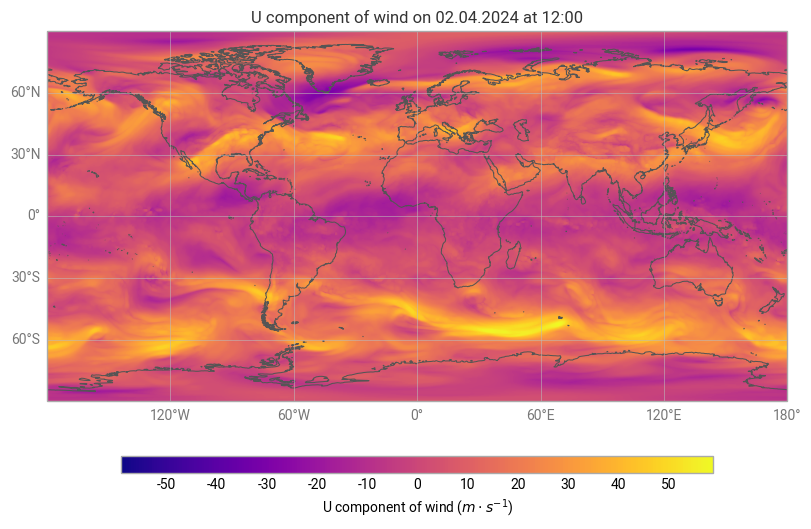

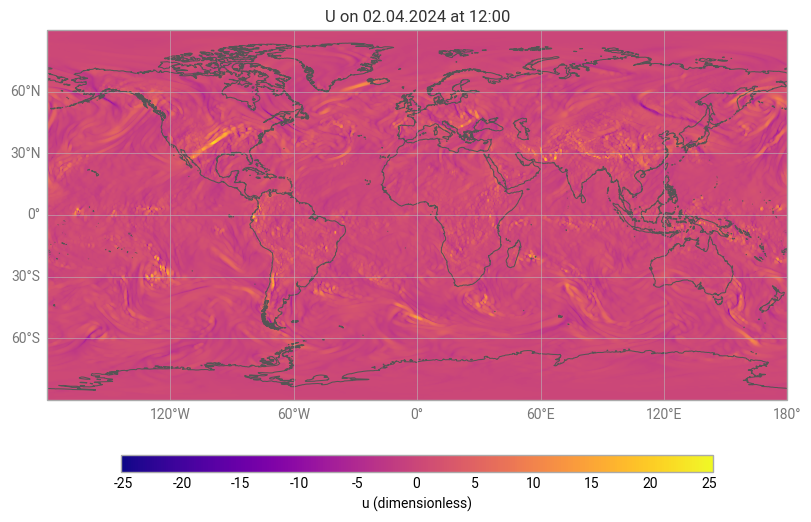

In [7]:
plot_data(ERA5_U, divergence_point=0)
plot_data(ERA5_U.differentiate("longitude"), divergence_point=0)

In [8]:
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_zero import ZeroCodec

from compression_safeguards import Safeguards

In [9]:
sg = Safeguards(
    safeguards=[
        dict(
            kind="qoi_eb_stencil",
            qoi=f"finite_difference(x, order=1, accuracy=2, type=0, axis=0, grid_spacing={dlon})",
            neighbourhood=[dict(axis=2, before=1, after=1, boundary="valid")],
            type="abs",
            eb=0.1,
        )
    ]
)

codec = ZeroCodec()

codec_sg = SafeguardsCodec(codec=codec, safeguards=sg.safeguards)

In [10]:
# Safely apply the safeguard to the entire data all at once
ERA5_U_sg = ERA5_U.copy(data=codec_sg.decode(codec_sg.encode(ERA5_U.values)))

In [11]:
def encode_decode_independent_chunk(
    data: np.ndarray,
    codec: Codec,
) -> np.ndarray:
    return codec.decode(codec.encode(data))  # type: ignore

In [12]:
"""
The following is UNSAFE since the the QoI stencil safeguard is applied
independently applied to each chunk, risking safety violations at the
chunk boundaries.
"""

ERA5_U_sg_unsafe_chunked = ERA5_U_chunked.copy(
    data=ERA5_U_chunked.data.map_blocks(
        encode_decode_independent_chunk,
        dtype=ERA5_U_chunked.dtype,
        chunks=None,
        enforce_ndim=True,
        meta=np.array((), dtype=ERA5_U_chunked.dtype),
        codec=codec_sg,
    )
).compute()

In [13]:
print(
    f"Unsafely chunked safeguards have {np.sum(ERA5_U_sg.values != ERA5_U_sg_unsafe_chunked.values)} differently corrected values"
)

Unsafely chunked safeguards have 4 differently corrected values


In [14]:
from compression_safeguards.safeguards.pointwise.abc import PointwiseSafeguard
from compression_safeguards.safeguards.stencil import NeighbourhoodAxis
from compression_safeguards.safeguards.stencil.abc import StencilSafeguard
from compression_safeguards.utils.bindings import Bindings

In [15]:
def safely_compute_chunked_data_array_correction(
    da: xr.DataArray,
    da_decoded: xr.DataArray,
    safeguards: Safeguards,
) -> xr.DataArray:
    assert da.chunks == da_decoded.chunks

    late_bound_reqs = tuple(safeguards.late_bound - safeguards.builtin_late_bound)

    # compute the late-bound data minimum and maximum
    da_min = np.nanmin(da) if da.size > 0 else np.array(0, dtype=da.dtype)
    da_max = np.nanmin(da) if da.size > 0 else np.array(0, dtype=da.dtype)

    # create the global built-in late-bound bindings with $x_min and $x_max
    late_bound_global = Bindings.empty()
    if "$x_min" in late_bound_reqs:
        late_bound_global = late_bound_global.update(**{"$x_min": da_min})
    if "$x_max" in late_bound_reqs:
        late_bound_global = late_bound_global.update(**{"$x_max": da_max})

    # special case for no chunking: just compute eagerly
    if da.chunks is None:
        # provide built-in late-bound bindings $d for the data dimensions
        late_bound = late_bound_global
        for i, d in enumerate(da.dims):
            if f"${d}" in late_bound_reqs:
                shape = [1 for _ in range(len(da.dims))]
                shape[i] = da.shape[i]
                late_bound = late_bound.update(**{f"${d}": da[d].values.reshape(shape)})

        return da.copy(
            data=safeguards.compute_correction(
                da.values, da_decoded.values, late_bound=late_bound
            )
        )

    # compute the required stencil / neighbourhood for the safeguards
    stencil = [NeighbourhoodAxis(0, 0) for _ in range(len(da.dims))]
    for safeguard in safeguards.safeguards:
        if isinstance(safeguard, StencilSafeguard):
            for i, s in enumerate(
                safeguard.compute_check_neighbourhood_for_data_shape(da.shape)
            ):
                if s is None:
                    continue
                stencil[i] = NeighbourhoodAxis(
                    before=max(stencil[i].before, s.before),
                    after=max(stencil[i].after, s.after),
                )
        else:
            assert isinstance(safeguard, PointwiseSafeguard), "unknown safeguard kind"

    correction_dtype = safeguards.correction_dtype_for_data(da.dtype)

    # provide built-in late-bound bindings $d for the data dimensions
    chunked_late_bound = dict()
    for i, d in enumerate(da.dims):
        if f"${d}" in late_bound_reqs:
            shape = [1 for _ in range(len(da.dims))]
            shape[i] = da.shape[i]
            chunked_late_bound[f"${d}"] = dask.array.broadcast_to(
                da[d].data,
                shape=shape,
                chunks=da.chunks,
                meta=np.array((), dtype=da[d].dtype),
            )

    # special case for no stencil: just apply independently to each chunk
    if all(s.before == 0 and s.after == 0 for s in stencil):

        def _compute_indepenent_chunk_correction(
            chunk: np.ndarray,
            chunk_decoded: np.ndarray,
            *late_bound_chunks: np.ndarray,
            late_bound_names: tuple[str],
            late_bound_global: Bindings,
            safeguards: Safeguards,
        ) -> np.ndarray:
            assert len(late_bound_chunks) == len(late_bound_names)

            late_bound = late_bound_global.update(
                **{p: v for p, v in zip(late_bound_names, late_bound_chunks)}
            )

            return safeguards.compute_correction(
                chunk, chunk_decoded, late_bound=late_bound
            )

        return da.copy(
            data=da.data.map_blocks(
                _compute_indepenent_chunk_correction,
                da_decoded.data,
                *chunked_late_bound.values(),
                dtype=correction_dtype,
                chunks=None,
                enforce_ndim=True,
                meta=np.array((), dtype=correction_dtype),
                late_bound_names=tuple(chunked_late_bound.keys()),
                late_bound_global=late_bound_global,
                safeguards=safeguards,
            )
        )

    # we now know that the safeguards have a stencil of [before, ..., x, ..., after]
    # this stencil is sufficient to compute the safeguard to x,
    # BUT the elements from before to after also contribute to the safe intervals of x
    # so we need to ensure that they have all of their stencil available as well
    # therefore we actually need to double the stencil to
    # [before-before, ..., before, ..., x, ..., after, ..., after+after]
    stencil = [
        NeighbourhoodAxis(before=s.before * 2, after=s.after * 2) for s in stencil
    ]

    def _compute_stencil_chunk_correction(
        chunk: np.ndarray,
        chunk_decoded: np.ndarray,
        *late_bound_chunks: np.ndarray,
        late_bound_names: tuple[str],
        late_bound_global: Bindings,
        safeguards: Safeguards,
    ) -> np.ndarray:
        assert len(late_bound_chunks) == len(late_bound_names)

        late_bound = late_bound_global.update(
            **{p: v for p, v in zip(late_bound_names, late_bound_chunks)}
        )

        # this is safe because
        # - map_overlap ensures we get chunks including their required stencil
        # - map_overlap with trim=True throws away the stencil corrections
        return safeguards.compute_correction(
            chunk, chunk_decoded, late_bound=late_bound
        )

    return da.copy(
        data=dask.array.map_overlap(
            _compute_stencil_chunk_correction,
            da.data,
            da_decoded.data,
            *chunked_late_bound.values(),
            dtype=correction_dtype,
            chunks=None,
            enforce_ndim=True,
            meta=np.array((), dtype=correction_dtype),
            depth=tuple((s.before, s.after) for s in stencil),
            boundary="none",
            trim=True,
            align_arrays=False,
            allow_rechunk=False,
            late_bound_names=tuple(chunked_late_bound.keys()),
            late_bound_global=late_bound_global,
            safeguards=safeguards,
        )
    )

In [16]:
def safely_apply_chunked_data_array_correction(
    da_decoded: xr.DataArray,
    da_correction: xr.DataArray,
    safeguards: Safeguards,
) -> xr.DataArray:
    assert da_decoded.chunks == da_correction.chunks

    def _apply_indepenent_chunk_correction(
        chunk_decoded: np.ndarray,
        chunk_correction: np.ndarray,
        safeguards: Safeguards,
    ) -> np.ndarray:
        return safeguards.apply_correction(chunk_decoded, chunk_correction)

    return da_decoded.copy(
        data=da_decoded.data.map_blocks(
            _apply_indepenent_chunk_correction,
            da_correction.data,
            dtype=da_decoded.dtype,
            chunks=None,
            enforce_ndim=True,
            meta=np.array((), dtype=da_decoded.dtype),
            safeguards=safeguards,
        )
    )

In [17]:
ERA5_U_chunked_decoded = ERA5_U_chunked.copy(
    data=ERA5_U_chunked.data.map_blocks(
        encode_decode_independent_chunk,
        dtype=ERA5_U_chunked.dtype,
        chunks=None,
        enforce_ndim=True,
        meta=np.array((), dtype=ERA5_U_chunked.dtype),
        codec=codec,
    )
)
ERA5_U_chunked_correction = safely_compute_chunked_data_array_correction(
    ERA5_U_chunked, ERA5_U_chunked_decoded, safeguards=sg
)

ERA5_U_sg_safe_chunked = safely_apply_chunked_data_array_correction(
    ERA5_U_chunked_decoded, ERA5_U_chunked_correction, safeguards=sg
).compute()

In [18]:
print(
    f"Safely chunked safeguards have {np.sum(ERA5_U_sg.values != ERA5_U_sg_safe_chunked.values)} differently corrected values"
)

Safely chunked safeguards have 0 differently corrected values
